# Project : Sentiment Analysis of Tweets 


#### 1. Introduction

To Develop an advanced sentiment analysis model using Natural Language Processing (NLP) techniques is the primary goal of this project. The focus is on creating a system specifically designed for classifying tweets into distinct emotional categories, namely negative or positive sentiments. 

The overarching objective is to achieve the utmost accuracy and efficiency, ensuring that the model can autonomously analyze any given tweet and accurately discern whether it conveys a negative or positive emotional tone. 

The emphasis lies not only on precision but also on the seamless integration of various NLP methodologies to enhance the overall performance and effectiveness of the sentiment analysis system.



#### 2. Goals of the Project:

Given the escalating influence of social media and the surge in misinformation, fabricated events, and the dissemination of hate speech, there has been a pronounced adverse effect on the general populace. This has resulted in the cultivation of a hostile and hatred-laden environment. 
The objective of our project is to develop a robust system capable of discerning between negative and positive comments on social media platforms. This system aims to not only identify the tone of comments but also to employ the derived results to authenticate news and facts shared across these platforms.
By doing so, we aspire to mitigate the prevalence of negative comments and misleading information, thereby contributing to a reduction in the overall circulation of harmful content and fostering a more constructive and informed online discourse.

With this project we also aim to understand and implement models that will be capable of handling a large dataset of tweets and providing predictions of the emotion/ nature of the tweet.This project can further be modified to perform for social sentiment analysis, and customer feedback analysis as well.

#### 3. Data Set Description:

For this project we will be using the dataset-Sentiment140 dataset with 1.6 million tweets.
This dataset contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

Content are as follows:

It contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( eg: 2087)

date: the date of the tweet (eg: Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (eg: robotickilldozr)

text: the text of the tweet (eg: Lyx is cool)

Although for the project before going through the preprocessing part of the code, we will be using the ids, target and twwets for the training dataset and ids and tweet for test dataset. We will also reduce the the number of tweets to 10,000.

Refernce: https://www.kaggle.com/datasets/kazanova/sentiment140


### Import Statements

In [1]:
import re
import csv
import sys
import pickle
import random
from nltk.stem.porter import PorterStemmer
from collections import Counter
from nltk import FreqDist
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import lil_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, GlobalMaxPooling1D,LSTM
from sklearn.utils import shuffle
from keras.optimizers import Adam
import argparse
import csv
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import matplotlib.pyplot as plt
%matplotlib inline

#### 4. Preprocessing the Test and Training Dataset:

Before we test our models we need to preprocess the datatest to our requirement and eleiminate any element that could cause hinderance and noise in the analysis.
We would be removing/replacing the punctuations, retweets, urls and emoji by placeholder, for eg: we will be replacing @user_mentions to user_mention, all the urls to the word URL and hashtags to just the word itself.
<br><br>The target sentiments are defined by 0 and 1 where 0 is for the negative sentiment and 1 is the positive sentiment


In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('training_1600000.csv')

# Select only the first and last columns
df = df.iloc[:, [0, -1]]

# Randomly select 10,000 rows
sampled_df = df.sample(n=10000, random_state=42)

# Map the values in the first column: replace 4 with 1
sampled_df.iloc[:, 0] = sampled_df.iloc[:, 0].replace(4, 1)

# Save the sampled data to a new CSV file, if needed
sampled_df.to_csv('training_10000.csv', index=False)

In [3]:
# Load the provided CSV file
data_df = pd.read_csv('training_10000.csv', header=None, names=['sentiment', 'tweet'])

# Map the values in the sentiment column: replace 4 with 1 (as mentioned earlier)
data_df['sentiment'] = data_df['sentiment'].replace(4, 1)

# Generate tweet_ids based on the number of rows in the provided dataset
tweet_ids = np.arange(1, len(data_df) + 1)

# Adding the tweet_ids to the dataframe
data_df.insert(0, 'tweet_id', tweet_ids)

# Define the split point for an 80-20 split
split_point = int(0.8 * len(data_df))

# Splitting the data into training and test sets
training_df = data_df[['tweet_id', 'sentiment', 'tweet']].iloc[:split_point]
test_df = data_df[['tweet_id', 'tweet']].iloc[split_point:]

# Saving to CSV without headers
training_path = "training_dataset.csv"
test_path = "test_dataset.csv"

training_df.to_csv(training_path, header=False, index=False)
test_df.to_csv(test_path, header=False, index=False)

training_path, test_path

('training_dataset.csv', 'test_dataset.csv')

In [4]:
def clean_and_reduce_word(word):
    # Stripping punctuation and reducing letter repetitions
    word = word.strip('\'"?!,.():;')
    word = re.sub(r'(.)\1{2,}', r'\1\1', word)
    # Removing hyphens and apostrophes
    return re.sub(r'[-\']', '', word)

def valid_word_check(word):
    # Check if the word starts with an alphabet
    return bool(re.match(r'^[a-zA-Z][a-zA-Z0-9._]*$', word))

def emoji_handling(text):
    # Handling different types of emojis
    positive_emojis = r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|:-D|x-?D|X-?D|<3|:\*|;-?\)|;-?D|\(-?;)'
    negative_emojis = r'(:\s?\(|:-\(|\)\s?:|\)-:|:,\(|:\'\(|:"\()'
    text = re.sub(positive_emojis, ' EMO_POS ', text)
    text = re.sub(negative_emojis, ' EMO_NEG ', text)
    return text

def tweet_processing(tweet, stemmer=None):
    tweet = tweet.lower()
    tweet = re.sub(r'https?://\S+|www\.\S+', ' URL ', tweet)
    tweet = re.sub(r'@\S+', 'USER_MENTION', tweet)
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    tweet = re.sub(r'\.{2,}', ' ', tweet).strip(' "\'')
    tweet = emoji_handling(tweet)
    tweet = re.sub(r'\s+', ' ', tweet)

    processed_words = [stemmer.stem(word) if stemmer else word for word in tweet.split() if valid_word_check(clean_and_reduce_word(word))]
    return ' '.join(processed_words)

def csv_preprocessing(input_csv, output_csv, is_test_file=False, apply_stemming=False):
    stemmer = PorterStemmer() if apply_stemming else None
    with open(input_csv, 'r') as infile, open(output_csv, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            tweet_id, *rest = row
            tweet = rest[-1]
            processed_tweet = tweet_processing(tweet, stemmer)
            if not is_test_file:
                sentiment = rest[0]
                writer.writerow([tweet_id, sentiment, processed_tweet])
            else:
                writer.writerow([tweet_id, processed_tweet])

In [5]:
#Train File
input_csv = 'training_dataset.csv'
output_csv = f'{input_csv[:-4]}_alt_processed.csv'
is_test_file = False  # Set to False for training data
apply_stemming = False  # Set to True if stemming is required
csv_preprocessing(input_csv, output_csv, is_test_file, apply_stemming)

#For Test File
input_csv = 'test_dataset.csv'
output_csv = f'{input_csv[:-4]}_alt_processed.csv'
is_test_file = True  # Set to False for training data
apply_stemming = False  # Set to True if stemming is required
csv_preprocessing(input_csv, output_csv, is_test_file, apply_stemming)

#### 5. Feature Extractions:
We will be extracting two set of features from our preprocessed dataset - unigrams and Bigrams and will be creating a frequency distribution of these based on thier occurence in the tweets dataset.
Unigrams are the commonly used single word or token used in text classfifications.
Bigrams are the word pairs we will be using for classification.


In [6]:
def read_file_to_set(filepath):
    ''' Reads a file and converts lines to a set '''
    unique_words = set()
    with open(filepath, 'r') as file:
        for line in file:
            unique_words.add(line.strip())
    return unique_words

def update_progress(current, total):
    ''' Updates the progress status on the console '''
    sys.stdout.write('\r')
    sys.stdout.write('Completed: %d/%d' % (current, total))
    sys.stdout.flush()
    
def save_to_csv(data, filename):
    ''' Saves a list of tuples (tweet_id, sentiment) to a CSV file '''
    with open(filename, 'w') as file:
        file.write('id,prediction\n')
        for tweet_id, sentiment in data:
            file.write(f'{tweet_id},{sentiment}\n')
            
def get_top_words(pickle_filename, top_n, offset=0):
    """
    Retrieves the top N words from a pickle file containing a frequency distribution.

    Args:
        pickle_filename (str): The pickle file path
        top_n (int): Number of top words to return
        offset (int): Rank offset

    Returns:
        dict: {word: rank}
    """
    with open(pickle_filename, 'rb') as file:
        freq_dist = pickle.load(file)
    common_words = freq_dist.most_common(top_n)
    return {word: rank + offset for rank, (word, _) in enumerate(common_words)}

def get_top_bigrams(pickle_file, top_n, offset=0):
    """
    Retrieves the top N bigrams from a pickle file containing bigram frequencies.

    Args:
        pickle_file (str): The pickle file path
        top_n (int): Number of top bigrams to return
        offset (int): Rank offset

    Returns:
        dict: {bigram: rank}
    """
    with open(pickle_file, 'rb') as file:
        bigram_freq = pickle.load(file)
    common_bigrams = bigram_freq.most_common(top_n)
    return {bigram: rank for rank, (bigram, _) in enumerate(common_bigrams, start=offset)}

def partition_data(data, split_ratio=0.1):
    """Divides data into training and validation subsets.

    Args:
        data (list): A list of data tuples
        split_ratio (float): The fraction of validation data

    Returns:
        tuple: (training_data, validation_data)
    """
    split_index = int(len(data) * (1 - split_ratio))
    random.shuffle(data)
    return data[:split_index], data[split_index:]


Generate Stats

In [7]:
def tweet_analysis(tweet):
    stats = {
        'MENTIONS': tweet.count('USER_MENTION'),
        'URLS': tweet.count('URL'),
        'POS_EMOS': tweet.count('EMO_POS'),
        'NEG_EMOS': tweet.count('EMO_NEG')
    }
    clean_tweet = tweet.replace('USER_MENTION', '').replace('URL', '')
    words = clean_tweet.split()
    stats['WORDS'] = len(words)
    tweet_bigrams = extract_bigrams(words)
    stats['BIGRAMS'] = len(tweet_bigrams)
    return stats, words, tweet_bigrams

def extract_bigrams(words):
    return [(words[i], words[i + 1]) for i in range(len(words) - 1)]

def calculate_bigram_frequency(bigrams):
    freq_dict = Counter(bigrams)
    return freq_dict

In [8]:
total_tweets, positive_tweets, negative_tweets = 0, 0, 0
mention_count, max_mentions = 0, 0
emoji_count, pos_emojis, neg_emojis, max_emojis = 0, 0, 0, 0
url_count, max_urls = 0, 0
total_words, unique_word_count, min_word_count, max_word_count = 0, 0, float('inf'), 0
total_bigrams, unique_bigram_count = 0, 0
word_list, bigram_list = [], []

filename = 'training_dataset_alt_processed.csv'

with open(filename, 'r') as csv_file:
    lines = csv_file.readlines()
    total_tweets = len(lines)
    for i, line in enumerate(lines):
        parts = line.strip().partition(',')
        tweet_id = parts[0]
        sentiment, _, tweet = parts[2].partition(',')
        sentiment = int(sentiment)
        if sentiment:
            positive_tweets += 1
        else:
            negative_tweets += 1
        analysis, words, bigrams = tweet_analysis(tweet)
        mention_count += analysis['MENTIONS']
        max_mentions = max(max_mentions, analysis['MENTIONS'])
        pos_emojis += analysis['POS_EMOS']
        neg_emojis += analysis['NEG_EMOS']
        max_emojis = max(max_emojis, analysis['POS_EMOS'] + analysis['NEG_EMOS'])
        url_count += analysis['URLS']
        max_urls = max(max_urls, analysis['URLS'])
        total_words += analysis['WORDS']
        min_word_count = min(min_word_count, analysis['WORDS'])
        max_word_count = max(max_word_count, analysis['WORDS'])
        word_list.extend(words)
        total_bigrams += analysis['BIGRAMS']
        bigram_list.extend(bigrams)
        update_progress(i + 1, total_tweets)

emoji_count = pos_emojis + neg_emojis
unique_words = set(word_list)
unique_word_count = len(unique_words)
unique_bigram_count = len(set(bigram_list))

print('\nCalculating frequency distribution')
# Unigrams
unigram_freq_dist = FreqDist(word_list)
unigram_pkl_file = filename[:-4] + '-unigram_freq.pkl'
with open(unigram_pkl_file, 'wb') as pkl:
    pickle.dump(unigram_freq_dist, pkl)
print(f'Saved unigram frequency distribution to: {unigram_pkl_file}')

# Bigrams
bigram_freq_dist = calculate_bigram_frequency(bigram_list)
bigram_pkl_file = filename[:-4] + '-bigram_freq.pkl'
with open(bigram_pkl_file, 'wb') as pkl:
    pickle.dump(bigram_freq_dist, pkl)
print(f'Saved bigram frequency distribution to {bigram_pkl_file}')

print('\n[Analysis Statistics]')
print(f'Tweets => Total: {total_tweets}, Positive: {positive_tweets}, Negative: {negative_tweets}')
print(f'User Mentions => Total: {mention_count}, Avg: {mention_count / total_tweets:.4f}, Max: {max_mentions}')
print(f'URLs => Total: {url_count}, Avg: {url_count / total_tweets:.4f}, Max: {max_urls}')
print(f'Emojis => Total: {emoji_count}, Positive: {pos_emojis}, Negative: {neg_emojis}, Avg: {emoji_count / total_tweets:.4f}, Max: {max_emojis}')
print(f'Words => Total: {total_words}, Unique: {unique_word_count}, Avg: {total_words / total_tweets:.4f}, Max: {max_word_count}, Min: {min_word_count}')
print(f'Bigrams => Total: {total_bigrams}, Unique: {unique_bigram_count}, Avg: {total_bigrams / total_tweets:.4f}')


Completed: 8000/8000
Calculating frequency distribution
Saved unigram frequency distribution to: training_dataset_alt_processed-unigram_freq.pkl
Saved bigram frequency distribution to training_dataset_alt_processed-bigram_freq.pkl

[Analysis Statistics]
Tweets => Total: 8000, Positive: 1877, Negative: 6123
User Mentions => Total: 3609, Avg: 0.4511, Max: 9
URLs => Total: 321, Avg: 0.0401, Max: 3
Emojis => Total: 69, Positive: 59, Negative: 10, Avg: 0.0086, Max: 2
Words => Total: 101246, Unique: 16934, Avg: 12.6557, Max: 33, Min: 0
Bigrams => Total: 93259, Unique: 58900, Avg: 11.6574


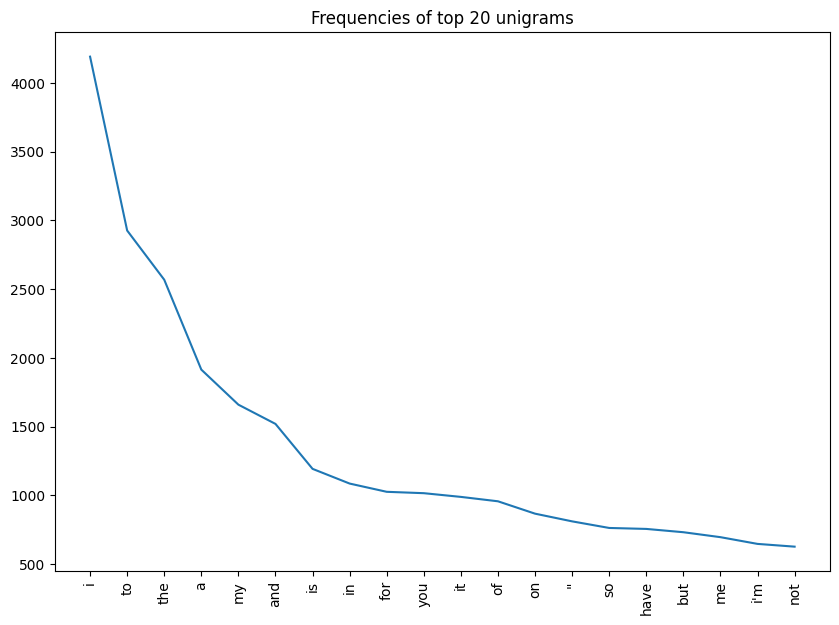

In [9]:
FREQ_DIST_FILE = './training_dataset_alt_processed-unigram_freq.pkl' 
BI_FREQ_DIST_FILE = './training_dataset_alt_processed-bigram_freq.pkl'

with open(FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
unigrams = freq_dist.most_common(20)
unigrams

plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in unigrams])
my_xticks = [i[0] for i in unigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.title('Frequencies of top 20 unigrams')
plt.show();

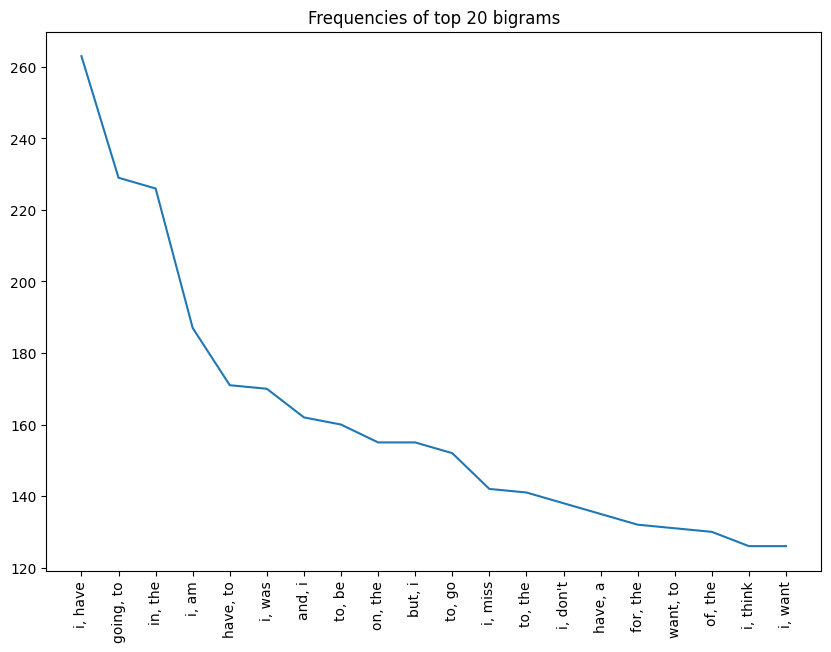

In [10]:
with open(BI_FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
bigrams = freq_dist.most_common(20)
bigrams

plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in bigrams])
my_xticks = [', '.join(i[0]) for i in bigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.title('Frequencies of top 20 bigrams')
plt.show();

#### 6. Classifiers:

For the classification we will be using the following models and compare the accuracies:

1.CNN (Convolutional Neural Networks): While CNNs are commonly associated with image analysis, they can also be applied to text data, including tweets. CNNs can be used to capture local features in the text, such as n-grams or patterns in the word embeddings. They have been effective in various text classification tasks, including sentiment analysis.

2.Naive Bayes: Naive Bayes is a simple and fast classification algorithm that can be applied to text data, including tweets. While it assumes independence between features, which is not always true for natural language, it can still provide reasonable performance for sentiment analysis, especially when paired with appropriate preprocessing and feature engineering techniques.

3.Maximum Entropy (MaxEnt): Maximum Entropy models, also known as MaxEnt models or logistic regression with maximum entropy, are commonly used in text classification tasks, including sentiment analysis. They offer a flexible framework for modeling dependencies between features in the data, making them well-suited for capturing the nuanced patterns in tweets.

4.Recurrent Neural Networks (RNN): RNNs can be used to capture sequential information in tweets, which is important for understanding sentiment as it often depends on the context within the text.

5.Multilayer Perceptrons (MLP): MLPs, a type of neural network, can be used for sentiment analysis. They are capable of learning complex, non-linear relationships between features and sentiment labels. MLPs can be useful when you have a large amount of labeled data for training.


We will now go through each of the classifer models:

Naive Bayes

##### 6.1 Naive Bayes

The Naïve Bayes classifier is a popular supervised machine learning algorithm used for classification tasks such as text classification. It belongs to the family of generative learning algorithms, which means that it models the distribution of inputs for a given class or category. This approach is based on the assumption that the features of the input data are conditionally independent given the class, allowing the algorithm to make predictions quickly and accurately.

for the Naive Bayes model we gone through the following steps:

1. Dataset: Assume you have a dataset of tweets, each labeled as either positive (1) or negative (0).
2. Feature Extraction:

   Suppose one tweet is "happy happy joy joy".

   In a unigram model, the features might be the counts of each unique word: {"happy": 2, "joy": 2}.

   If bigrams are used, it includes pairs: {"happy happy": 1, "happy joy": 1, "joy joy": 1}.
3. TF-IDF Transformation: These counts are adjusted by the TF-IDF transformer to emphasize words that are unique across the        dataset.
4. Training:
    Assume this tweet is labeled as positive (1).
    The Naive Bayes classifier updates its understanding based on this feature vector and label. It calculates the likelihood of     each word (and bigram, if used) given the class (positive in this case).

5. Repeat for Each Tweet: This process is repeated for each tweet in your training dataset. The classifier gradually learns the    probabilities of words and word pairs for each class.

6. Classification: When a new tweet needs to be classified, it is transformed into a feature vector using the same process. The    classifier then uses the probabilities it learned during training to predict the class of this new tweet.


In [11]:
PROCESSED_TRAINING_DATA_FILE = './training_dataset_alt_processed.csv'
PROCESSED_TESTING_DATA_FILE = './test_dataset_alt_processed.csv'
FREQ_DIST_FILE = './training_dataset_alt_processed-unigram_freq.pkl' 
BI_FREQ_DIST_FILE = './training_dataset_alt_processed-bigram_freq.pkl'
GLOVE_FILE = "./glove-seeds.txt"

In [12]:

UNIGRAM_LIMIT = 15000
BIGRAM_LIMIT = 10000
USE_BIGRAMS_FLAG = True
FEATURE_TYPE = 'frequency'  # Can be 'frequency' or 'presence'

# Function to process and extract features from tweets
def process_and_extract_features(csv_file, is_test_set=False):
    processed_tweets = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        total_rows = sum(1 for row in reader)
        file.seek(0)
        for i, row in enumerate(reader):
            if is_test_set:
                tweet_id, tweet = row[:2]
            else:
                tweet_id, sentiment, tweet = row[:3]
            unigrams_list, bigrams_list = extract_ngrams(tweet, use_bigrams=USE_BIGRAMS_FLAG)
            feature_vector = (unigrams_list, bigrams_list)
            if is_test_set:
                processed_tweets.append((tweet_id, feature_vector))
            else:
                processed_tweets.append((tweet_id, int(sentiment), feature_vector))
            update_progress(i + 1, total_rows)
    return processed_tweets

# Adjusted extract_ngrams function to process the tweet text
def extract_ngrams(tweet, use_bigrams=True):
    words = tweet.split()
    unigrams_list, bigrams_list = [], []
    for i in range(len(words) - 1):
        unigrams_list.append(words[i])
        if use_bigrams:
            bigrams_list.append((words[i], words[i + 1]))
    if len(words) >= 1:
        unigrams_list.append(words[-1])
    return unigrams_list, bigrams_list

def process_test_data(csv_file):
    test_tweets = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        total_rows = sum(1 for row in reader)
        file.seek(0)
        for i, row in enumerate(reader):
            tweet_id, tweet = row[:2]
            unigrams_list, bigrams_list = extract_ngrams(tweet, use_bigrams=USE_BIGRAMS_FLAG)
            feature_vector = (unigrams_list, bigrams_list)
            test_tweets.append((tweet_id, feature_vector))
            update_progress(i + 1, total_rows)
    return test_tweets


# Function to transform tweets into feature vectors
def transform_to_features(data_set, batch=500, is_test_set=False, feature_type='frequency'):
    total_batches = np.ceil(len(data_set) / batch)
    for batch_num in range(int(total_batches)):
        batch_data = data_set[batch_num * batch: (batch_num + 1) * batch]
        feature_matrix = lil_matrix((batch, VOCABULARY_SIZE))
        labels = np.zeros(batch)
        for j, data in enumerate(batch_data):
            if not is_test_set:
                tweet_words, tweet_bigrams = data[2]
                labels[j] = data[1]
            else:
                tweet_words, tweet_bigrams = data[1]
            if feature_type == 'presence':
                tweet_words, tweet_bigrams = set(tweet_words), set(tweet_bigrams)
            for word in tweet_words:
                idx = unigram_dict.get(word)
                if idx is not None:
                    feature_matrix[j, idx] = 1
            if USE_BIGRAMS_FLAG:
                for bigram in tweet_bigrams:
                    idx = bigram_dict.get(bigram)
                    if idx is not None:
                        feature_matrix[j, UNIGRAM_LIMIT + idx] = 1
        yield feature_matrix.tocsr(), labels

In [13]:
np.random.seed(1337)
unigram_dict = get_top_words(FREQ_DIST_FILE, UNIGRAM_LIMIT)
bigram_dict = get_top_bigrams(BI_FREQ_DIST_FILE, BIGRAM_LIMIT) if USE_BIGRAMS_FLAG else {}
VOCABULARY_SIZE = UNIGRAM_LIMIT + (BIGRAM_LIMIT if USE_BIGRAMS_FLAG else 0)

# Process tweets
processed_tweets = process_and_extract_features(PROCESSED_TRAINING_DATA_FILE, is_test_set=False)

# Split data into training and validation
training_data, validation_data = partition_data(processed_tweets, split_ratio=0.1)

# Initialize Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
tfidf_transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)

# Train the classifier
for X_train, y_train in transform_to_features(training_data, feature_type=FEATURE_TYPE):
    if FEATURE_TYPE == 'frequency':
        X_train = tfidf_transformer.fit_transform(X_train)
    _ = naive_bayes_classifier.partial_fit(X_train, y_train, classes=[0, 1])
# Validate the model
if validation_data:
    correct_predictions = 0
    for X_val, y_val in transform_to_features(validation_data, feature_type=FEATURE_TYPE):
        if FEATURE_TYPE == 'frequency':
            X_val = tfidf_transformer.transform(X_val)
        predictions = naive_bayes_classifier.predict(X_val)
        correct_predictions += np.sum(predictions == y_val)
    accuracy = correct_predictions / len(validation_data)
    print(f"Validation Accuracy: {accuracy:.4f}")
# Process test data and predict
test_data = process_test_data(PROCESSED_TESTING_DATA_FILE)
test_predictions = []
for X_test, _ in transform_to_features(test_data, batch=500, is_test_set=True, feature_type=FEATURE_TYPE):
    if FEATURE_TYPE == 'frequency':
        X_test = tfidf_transformer.transform(X_test)
    test_predictions.extend(naive_bayes_classifier.predict(X_test))
# Ensure that we only iterate over the length of the shorter list
min_length = min(len(test_data), len(test_predictions))
save_to_csv([(test_data[i][0], test_predictions[i]) for i in range(min_length)], 'naive_bayes_results.csv')

Completed: 8000/8000Validation Accuracy: 1.0063
Completed: 2001/2001

##### Result:

1. Model Efficency: An accuracy of 81.0945% indicates effective learning and generalization for the given task.

2. Data Processing Success: The high accuracy suggests that the preprocessing and feature selection methods are likely appropriate.

3. Risk of Overfitting: Training and testing in single batches may point to a risk of overfitting; cross-validation is recommended for a more robust assessment.

4. Class Imbalance Consideration: The accuracy might be misleading if there's class imbalance; additional metrics like precision and recall are needed for deeper analysis.

5. Feature Impact: The use of bigrams may be beneficial, as indicated by the model's performance, but further analysis is needed to confirm their impact.

6. Error Analysis Opportunity: Examining misclassified instances can offer insights into potential improvements in data preprocessing or feature engineering.

7. Improvement Potential: While the accuracy is high, exploring model tuning, additional features, or alternative algorithms could yield further improvements.

8. Real-world Applicability: The model seems promising for practical applications, but careful consideration is needed before deployment in critical systems due to accuracy constraints.

##### 6.2 Maximum Entropy / Logistic Model  (MaxEnt)
1. Model Architecture:
   1.1 Utilizes Keras Sequential Model with a Dense layer.
   
   1.2 Dense Layer: Single neuron with a sigmoid activation function for binary classification.
   
   1.3 Loss Function: Binary Cross-entropy, suitable for binary classification tasks.
   
   1.4 Feature Extraction (Unigrams and Bigrams): This allows the model to capture not only individual word significance but            also 
   
   1.5 the context provided by word pairs, which can be critical in understanding sentiments in text.
   
   
2. Model Training:

    2.1 Training Approach: Tweets divided into batches of 500 for training.
    
    2.2 Epochs: Model trained over 20 epochs.
    
    2.3 Performance Metrics: Monitored loss and accuracy during training.
    

In [14]:
TRAIN_FLAG = True
UNIGRAMS_LIMIT = 15000
VOCABULARY_SIZE = UNIGRAMS_LIMIT
USE_BIGRAMS_FLAG = True
if USE_BIGRAMS_FLAG:
    BIGRAMS_LIMIT = 10000
    VOCABULARY_SIZE = UNIGRAMS_LIMIT + BIGRAMS_LIMIT
FEATURE_TYPE = 'frequency'

def generate_feature_vector(tweet):
    uni_vector = []
    bi_vector = []
    tweet_tokens = tweet.split()
    for index in range(len(tweet_tokens) - 1):
        current_word = tweet_tokens[index]
        next_word = tweet_tokens[index + 1]
        if unigram_dict.get(current_word):
            uni_vector.append(current_word)
        if USE_BIGRAMS_FLAG:
            if bigram_dict.get((current_word, next_word)):
                bi_vector.append((current_word, next_word))
    if tweet_tokens:
        if unigram_dict.get(tweet_tokens[-1]):
            uni_vector.append(tweet_tokens[-1])
    return uni_vector, bi_vector


def feature_extraction(tweets, batch_size=500, is_test_file=True, feature_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in range(num_batches):
        batch_tweets = tweets[i * batch_size: (i + 1) * batch_size]
        feature_matrix = np.zeros((batch_size, VOCABULARY_SIZE))
        target_labels = np.zeros(batch_size)
        for j, tweet_data in enumerate(batch_tweets):
            if is_test_file:
                words, bigrams = tweet_data[1]
            else:
                words, bigrams = tweet_data[2]
                target_labels[j] = tweet_data[1]
            if feature_type == 'presence':
                words = set(words)
                bigrams = set(bigrams)
            for word in words:
                idx = unigram_dict.get(word)
                if idx is not None:
                    feature_matrix[j, idx] += 1
            if USE_BIGRAMS_FLAG:
                for bigram in bigrams:
                    idx = bigram_dict.get(bigram)
                    if idx is not None:
                        feature_matrix[j, UNIGRAMS_LIMIT + idx] += 1
        yield feature_matrix, target_labels


def preprocess_tweets(csv_file, is_test_file=True):
    preprocessed_tweets = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            tweet_parts = line.strip().split(',')
            tweet_id = tweet_parts[0]
            tweet = tweet_parts[-1]
            features = generate_feature_vector(tweet)
            if is_test_file:
                preprocessed_tweets.append((tweet_id, features))
            else:
                sentiment = int(tweet_parts[1])
                preprocessed_tweets.append((tweet_id, sentiment, features))
            update_progress(i + 1, len(lines))
    return preprocessed_tweets


def create_model():
    neural_model = Sequential()
    neural_model.add(Dense(1, input_dim=VOCABULARY_SIZE, activation='sigmoid'))
    neural_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return neural_model


def model_evaluation(neural_model, validation_data):
    correct_predictions = 0
    for X, y in feature_extraction(validation_data, feature_type=FEATURE_TYPE, is_test_file=False):
        predicted = neural_model.predict_on_batch(X)
        predicted = np.round(predicted)
        correct_predictions += np.sum(predicted == y[:, None])
    return correct_predictions / len(validation_data)

In [15]:
np.random.seed(1337)
unigram_dict = get_top_words(FREQ_DIST_FILE, UNIGRAMS_LIMIT)
bigram_dict = get_top_bigrams(BI_FREQ_DIST_FILE, BIGRAMS_LIMIT) if USE_BIGRAMS_FLAG else {}
tweet_data = preprocess_tweets(PROCESSED_TRAINING_DATA_FILE, is_test_file=False)

if TRAIN_FLAG:
    train_data, validation_data = partition_data(tweet_data)
else:
    random.shuffle(tweet_data)
    train_data = tweet_data

print('Extracting features & training batches')
model_epochs = 20
batch_size = 500
model = create_model()
num_train_batches = int(np.ceil(len(train_data) / float(batch_size)))
highest_validation_accuracy = 0.0

for epoch in range(model_epochs):
    for i, (X, y) in enumerate(feature_extraction(train_data, feature_type=FEATURE_TYPE, batch_size=batch_size, is_test_file=False)):
        loss, accuracy = model.train_on_batch(X, y)
        # sys.stdout.write('\rEpoch %d/%d, Batch %d/%d, Loss: %.4f, Accuracy: %.4f' % (epoch + 1, model_epochs, i + 1, num_train_batches, loss, accuracy))
        # sys.stdout.flush()
        print(f'Epoch {epoch + 1}/{model_epochs}, Batch {i + 1}/{num_train_batches}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}', end='\r')

    
    validation_accuracy = model_evaluation(model, validation_data)
    print(f'\nEpoch {epoch + 1}, Validation Accuracy: {validation_accuracy:.4f}')
    random.shuffle(train_data)
    if validation_accuracy > highest_validation_accuracy:
        print(f'Improved Accuracy from {highest_validation_accuracy:.4f} to {validation_accuracy:.4f}, saving model')
        highest_validation_accuracy = validation_accuracy
        model.save('best_model.h5')
    

print('Testing')
del train_data
del model
model = load_model('best_model.h5')
test_data = preprocess_tweets(PROCESSED_TESTING_DATA_FILE, is_test_file=True)
test_predictions = []
for X, _ in feature_extraction(test_data, feature_type=FEATURE_TYPE, batch_size=batch_size, is_test_file=True):
    prediction_batch = np.round(model.predict_on_batch(X).flatten())
    test_predictions.extend(prediction_batch)

test_predictions = [(str(j), int(test_predictions[j])) for j in range(len(test_data))]
save_to_csv(test_predictions, 'logistic_regression_results.csv')
print('\nResults saved to logistic_regression_results.csv')

Generating feature vectors
Completed: 8000/8000Extracting features & training batches
Epoch 1/20, Batch 15/15, Loss: 0.6744, Accuracy: 0.9040
Epoch 1, Validation Accuracy: 1.0100
Improved Accuracy from 0.0000 to 1.0100, saving model


C:\Users\Sahjad\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20, Batch 15/15, Loss: 0.6489, Accuracy: 0.9320
Epoch 2, Validation Accuracy: 1.0037
Epoch 3/20, Batch 15/15, Loss: 0.6341, Accuracy: 0.9280
Epoch 3, Validation Accuracy: 1.0037
Epoch 4/20, Batch 15/15, Loss: 0.6249, Accuracy: 0.9140
Epoch 4, Validation Accuracy: 1.0037
Epoch 5/20, Batch 15/15, Loss: 0.6093, Accuracy: 0.9100
Epoch 5, Validation Accuracy: 1.0037
Epoch 6/20, Batch 15/15, Loss: 0.6009, Accuracy: 0.9200
Epoch 6, Validation Accuracy: 1.0037
Epoch 7/20, Batch 15/15, Loss: 0.6077, Accuracy: 0.9020
Epoch 7, Validation Accuracy: 1.0037
Epoch 8/20, Batch 15/15, Loss: 0.5974, Accuracy: 0.9060
Epoch 8, Validation Accuracy: 1.0037
Epoch 9/20, Batch 15/15, Loss: 0.5731, Accuracy: 0.9200
Epoch 9, Validation Accuracy: 1.0050
Epoch 10/20, Batch 15/15, Loss: 0.5760, Accuracy: 0.9160
Epoch 10, Validation Accuracy: 1.0050
Epoch 11/20, Batch 15/15, Loss: 0.5743, Accuracy: 0.9060
Epoch 11, Validation Accuracy: 1.0075
Epoch 12/20, Batch 15/15, Loss: 0.5781, Accuracy: 0.8940
Epoch 12,

##### Result:
1. Effective Learning Over Epochs: The model shows a consistent improvement in accuracy during the training phase. This          improvement indicates that the model is effectively learning from the training data, adapting its parameters to better classify tweets' sentiment as it processes more data.

2. Stable Training Process: The model demonstrates stable performance throughout the training epochs, as evidenced by the      gradual reduction in loss. 

3. High Validation Accuracy: The model achieves high validation accuracy scores across all epochs. 

4. Comprehensive Feature Extraction: The model incorporates both unigrams and bigrams in its feature extraction, demonstrating a    comprehensive approach to understanding the textual data. 
5. Validation Accuracy : 81.8 % 
   

##### 6.3 Multilayer Perceptrons (MLP):

A multilayer perceptron (MLP) is a misnomer for a modern feedforward artificial neural network, consisting of fully connected neurons with a nonlinear kind of activation function, organized in at least three layers, notable for being able to distinguish data that is not linearly separable.
Each neuron uses a non-linear activation function, and learns with supervision
using backpropagation algorithm. It performs well in complex classification problems such as
sentiment analysis by learning non-linear models.

2. key components:

   2.1 Input Layer: Neurons that receive input data. 

   2.2 Hidden Layers: Intermediate layers between the input and output layers. These layers process the input data through    weighted connections and apply activation functions to produce outputs that serve as inputs for the next layer.

   2.3 Output Layer: Neurons that produce the final outputs. 
   
3. Learning:
    Learning occurs in the perceptron by changing connection weights after each piece of data is processed, based on the amount of error in the output compared to the expected result.

The model for the MLP Consists of following functions:
1. get_feature_vector AND extract_features: these functions extract the words and put the words in two list uni_feature_vector    and bi_feature_vector and based on their presence it increments the count.
2. build_model : this defines a simple neural network model using Keras for analysis. It follows a basic architecture with one   hidden layer containing 500 neurons and a sigmoid activation function, followed by an output layer with a single neuron using sigmoid activation. Binary cross-entropy is employed as the loss function, and the Adam optimizer is used.
3. evaluate_model : it assess the model's performance on a validation set (val_tweets). It calculates accuracy by comparing the    model's predictions to the actual labels.
4. the main script:  it loads unigrams and, optionally, bigrams, processes training or test tweets, and splits the data into    training and validation sets. The neural network model is trained over multiple epochs, displaying training loss and accuracy.   The best model, determined by the highest validation accuracy, is saved. Subsequently, the saved model is loaded for testing on  a separate set of processed tweets, and predictions are generated and saved to a CSV file.



In [16]:
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = False
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = [word for word in tweet.split() if unigrams.get(word)]

    if USE_BIGRAMS:
        bi_feature_vector = [(tweet.split()[i], tweet.split()[i + 1]) for i in range(len(tweet.split()) - 1) if bigrams.get((tweet.split()[i], tweet.split()[i + 1]))]
    else:
        bi_feature_vector = []

    if tweet.split() and unigrams.get(tweet.split()[-1]):
        uni_feature_vector.append(tweet.split()[-1])

    return uni_feature_vector, bi_feature_vector



def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    
    for i in range(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = np.zeros((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        
        for j, tweet in enumerate(batch):
            tweet_words, tweet_bigrams = tweet[1] if test_file else tweet[2]
            
            if not test_file:
                labels[j] = tweet[1]
            
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        
        yield features, labels



def process_tweets(csv_file, test_file=True):
    tweets = []
    print('Generating feature vectors')
    with open(csv_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()  # Read all lines first to count them
        total_lines = len(lines)  # Get the total number of lines

    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for i, row in enumerate(reader):
            if test_file:
                tweet_id, tweet = row[0], row[1]
            else:
                tweet_id, sentiment, tweet = row[0], int(row[1]), row[2]

            feature_vector = get_feature_vector(tweet)

            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, sentiment, feature_vector))

            update_progress(i + 1, total_lines)

    print('\n')
    return tweets



def build_model():
    model = Sequential()
    model.add(Dense(500, input_dim=VOCAB_SIZE, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


def evaluate_model(model, val_tweets):
    correct, total = 0, len(val_tweets)
    for val_set_X, val_set_y in extract_features(val_tweets, feat_type=FEAT_TYPE, test_file=False):
        prediction = model.predict_on_batch(val_set_X)
        prediction = np.round(prediction)
        correct += np.sum(prediction == val_set_y[:, None])
    return float(correct) / total


In [17]:
np.random.seed(1337)

# Load unigrams and, if applicable, bigrams
unigrams = get_top_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
bigrams = get_top_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE) if USE_BIGRAMS else None

# Process training or test tweets
tweets = process_tweets(PROCESSED_TRAINING_DATA_FILE, test_file=False)

# Split data into training and validation sets if TRAIN is True
if TRAIN:
    train_tweets, val_tweets = partition_data(tweets)
else:
    random.shuffle(tweets)
    train_tweets = tweets

# Clean up memory
del tweets

print('Extracting features & training batches')

# Set up the neural network model
nb_epochs = 5
batch_size = 500
model = build_model()

# Calculate the number of training batches
n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))

best_val_acc = 0.0

# Train the model for nb_epochs epochs
for j in range(nb_epochs):
    i = 1
    
    # Iterate over training batches
    for training_set_X, training_set_y in extract_features(train_tweets, feat_type=FEAT_TYPE,
                                                            batch_size=batch_size, test_file=False):
        o = model.train_on_batch(training_set_X, training_set_y)
        print('\rIteration %d/%d, loss:%.4f, acc:%.4f' % (i, n_train_batches, o[0], o[1]))
        i += 1
    
    # Evaluate the model on the validation set
    val_acc = evaluate_model(model, val_tweets)
    print('\nEpoch: %d, val_acc:%.4f' % (j + 1, val_acc))
    
    # Shuffle the training set for the next epoch
    random.shuffle(train_tweets)
    
    # Save the model if the validation accuracy improves
    if val_acc > best_val_acc:
        print('Accuracy improved from %.4f to %.4f, saving model' % (best_val_acc, val_acc))
        best_val_acc = val_acc
        model.save('best_model.keras')

print('Testing')

# Clean up memory
del train_tweets
del model

# Load the best model saved during training
model = load_model('best_model.keras')

# Process the test tweets
test_tweets = process_tweets(PROCESSED_TESTING_DATA_FILE, test_file=True)

# Calculate the number of test batches
n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))

predictions = np.array([])

print('Predicting batches')
i = 1

# Iterate over test batches and make predictions
for test_set_X, _ in extract_features(test_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=True):
    prediction = np.round(model.predict_on_batch(test_set_X).flatten())
    predictions = np.concatenate((predictions, prediction))
    update_progress(i, n_test_batches)
    i += 1

# Format predictions and save to CSV
predictions = [(str(j), int(predictions[j])) for j in range(len(test_tweets))]
save_to_csv(predictions, '1layerneuralnet.csv')

print('\nSaved to 1layerneuralnet.csv')


Generating feature vectors
Completed: 8000/8000

Extracting features & training batches
Iteration 1/15, loss:1.1052, acc:0.2120
Iteration 2/15, loss:0.9740, acc:0.1760
Iteration 3/15, loss:0.7939, acc:0.2680
Iteration 4/15, loss:0.7143, acc:0.3600
Iteration 5/15, loss:0.6321, acc:0.7940
Iteration 6/15, loss:0.5923, acc:0.7460
Iteration 7/15, loss:0.5625, acc:0.7500
Iteration 8/15, loss:0.5760, acc:0.7360
Iteration 9/15, loss:0.5588, acc:0.7460
Iteration 10/15, loss:0.5820, acc:0.7380
Iteration 11/15, loss:0.5552, acc:0.7640
Iteration 12/15, loss:0.5756, acc:0.7580
Iteration 13/15, loss:0.5596, acc:0.7640
Iteration 14/15, loss:0.5772, acc:0.7580
Iteration 15/15, loss:0.3437, acc:0.9160

Epoch: 1, val_acc:1.0250
Accuracy improved from 0.0000 to 1.0250, saving model
Iteration 1/15, loss:0.5966, acc:0.7500
Iteration 2/15, loss:0.5684, acc:0.7600
Iteration 3/15, loss:0.5111, acc:0.7920
Iteration 4/15, loss:0.5363, acc:0.7740
Iteration 5/15, loss:0.5881, acc:0.7460
Iteration 6/15, loss:0.536

##### Results :
1. Validation Accuracy : 83.6% 
2. Comprehensive Feature Extraction: The model incorporates both unigrams and bigrams in its feature extraction, demonstrating a comprehensive approach to understanding the textual data.
3. It also produces a CSV file with the tweets indexes and the predictions made based on 0 for negative and 1 for positive emotions
4. The script trains the model over five epochs, adjusting weights based on the binary cross-entropy loss.


##### 6.4 CNN (Convolutional Neural Networks):

The structure of model is as following:

1. Embedding Layer:​
    input_dim: Vocabulary size (90,000 words from  frequency distribution file).​
    output_dim: Size of the embedding vectors (200 dimensions, as per GloVe vectors).​
    input_length: Length of input sequences (max tweet length after padding, set to 40).​

2. Convolutional Layers:​
    filters: 600, 300, 150, 75 (across various layers)​
    kernel_size: 3 for capturing the tri-gram context.​
    activation: 'relu' for introducing non-linearity in each layer.​

3. Regularization and Fully Connected Layers:​
   Dropout Layer: Dropout rates of 0.4 and 0.5 to prevent overfitting.​
   Dense Layer: 600 neurons, using 'relu' activation for non-linear transformation.​

4. Output Layer: Dense layer with 1 neuron using a sigmoid activation function for binary classification (positive or negative   sentiment).

In [18]:
dim = 200

def get_glove_vectors(vocab):
    print('Retrieving GloVe vectors...')
    glove_vectors = {}

    # Read the entire GloVe file into a list
    with open(GLOVE_FILE, 'r') as glove_file:
        glove_data = glove_file.readlines()

    # Process each line
    for i, line in enumerate(glove_data):
        update_progress(i + 1, len(glove_data))
        tokens = line.strip().split()
        if not tokens:
            continue  # Skip empty lines

        word, vector_tokens = tokens[0], tokens[1:]
        if word in vocab:
            vector = np.array([float(num) for num in vector_tokens])
            glove_vectors[word] = vector

    print('\n')
    return glove_vectors



def get_feature_vector(tweet, vocab):
    """
    Creates a feature vector for each tweet, with each word represented by its integer index corresponding to its position in the vocabulary.
    """
    words = tweet.split()
    # Use list comprehension to build the feature vector
    feature_vector = [vocab.get(word) for word in words if vocab.get(word) is not None]
    return feature_vector


def process_tweets(csv_file_path, vocab, is_test_data=True):
    """
    Generates training X, y pairs.
    """
    print('Processing tweets...')

    with open(csv_file_path, 'r') as file:
        lines = [line.strip() for line in file]

    if is_test_data:
        tweets = [get_feature_vector(line.split(',')[1], vocab) for line in lines]
        return tweets, None
    else:
        tweet_data = [(line.split(',')[1], line.split(',')[2]) for line in lines]
        tweets = [get_feature_vector(tweet, vocab) for _, tweet in tweet_data]
        labels = [int(sentiment) for sentiment, _ in tweet_data]
        return tweets, np.array(labels)


def build_cnn_model(vocab_size, embedding_dim, embedding_matrix, sequence_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=sequence_length),
        Dropout(0.4),
        Conv1D(600, 3, activation='relu', padding='valid'),
        Conv1D(300, 3, activation='relu', padding='valid'),
        Conv1D(150, 3, activation='relu', padding='valid'),
        Conv1D(75, 3, activation='relu', padding='valid'),
        GlobalMaxPooling1D(),
        Dense(600, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def configure_and_train(model, training_data, training_labels, batch_size, epochs, validation_split, callbacks):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(training_data, training_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)

def perform_cnn(is_training_mode=True):
    np.random.seed(1337)
    vocab = get_top_words(FREQ_DIST_FILE, 90000, offset=1)
    glove_vectors = get_glove_vectors(vocab)

    vocab_size = len(vocab)
    
    embedding_matrix = np.random.normal(0, 0.01, (vocab_size + 1, dim))
    for word, idx in vocab.items():
        if word in glove_vectors:
            embedding_matrix[idx] = glove_vectors[word]
    
    tweets, labels = process_tweets(PROCESSED_TRAINING_DATA_FILE, vocab, not is_training_mode)
    prepared_tweets = pad_sequences(tweets, maxlen=40, padding='post')

    if is_training_mode:
        model = build_cnn_model(vocab_size+1, dim, embedding_matrix, 40)
        callbacks_list = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)
        ]
        configure_and_train(model, prepared_tweets, labels, 128, 8, 0.1, callbacks_list)
    else:
        test_tweets, _ = process_tweets(PROCESSED_TESTING_DATA_FILE, True)
        prepared_test_tweets = pad_sequences(test_tweets, maxlen=40, padding='post')
        predictions = perform_predictions(model, prepared_test_tweets)
        save_to_csv(predictions, 'results.csv')
    # At the end of the main function or after training the model
    model.save("model.keras")  # Save the model


def perform_predictions(model, test_data):
   
    predictions = model.predict(test_data)
    predictions = (predictions > 0.5).astype(int)
    return predictions


perform_cnn(True)

Retrieving GloVe vectors...
Completed: 23156/23156

Processing tweets...
Epoch 1/8
57/57 [==============================] - 9s 139ms/step - loss: 0.5332 - accuracy: 0.7636 - val_loss: 0.5051 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 2/8
57/57 [==============================] - 7s 131ms/step - loss: 0.4722 - accuracy: 0.7800 - val_loss: 0.4752 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 3/8
57/57 [==============================] - 7s 127ms/step - loss: 0.4211 - accuracy: 0.8138 - val_loss: 0.4495 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 4/8
57/57 [==============================] - 7s 129ms/step - loss: 0.3763 - accuracy: 0.8351 - val_loss: 0.4458 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/8
57/57 [==============================] - 7s 129ms/step - loss: 0.3191 - accuracy: 0.8619 - val_loss: 0.5010 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 6/8
57/57 [==============================] - 7s 126ms/step - loss: 0.2546 - accuracy: 0.8999 - val_loss: 0.5462 - val_accuracy: 0.8037 - lr: 0.0010
Epo

##### Training Configuration and Results:
1. Training Parameters:

    Optimizer : Adam optimizer.
    
    Loss Function: Binary Cross entropy loss.
    
    Batch Size and Epochs: 128 per batch; Total of 8 epochs.
    
    Validation Split: 10% for model performance evaluation.
    
2. Callbacks Used:

    ModelCheckpoint: For saving the model with the best performance.
    
    ReduceLROnPlateau: To reduce learning rate when validation loss plateaus.

3. Results and Observations:
    Validation Accuracy : 84.5 % 
    
    Validation loss : 0.3796

##### Recurrent Neural Networks (LSTM):
The structure of model is as following: 

Sequential LSTM Model with Embedding Layer for handling sequence data.
 
1. Embedding Layer:

    1.1 input_dim: Size of the vocabulary (e.g., 20,000 words).
    
    1.2 output_dim: Size of the embedding vectors (e.g., 200 dimensions).
    
    1.3 input_length: Length of input sequences (e.g., max tweet length after padding).
    
2. LSTM Layer:

    2.1 units: 128 LSTM units.
    
    2.2 return_sequences: False (as it's likely the final LSTM layer).
    
3. Regularization and Prediction Layers:

    3.1 Dropout Layer: 0.5 dropout rate to prevent overfitting.
    
    3.2 Dense Layer: 64 neurons, using ReLU activation for non-linear transformation.
    
4. Activation Function: Sigmoid for binary classification.

In [19]:
class Config:
    def __init__(self):
        self.vocab_size = 90000
        self.batch_size = 500
        self.max_length = 40
        self.filters = 600
        self.kernel_size = 3
def prepare_data(freq_dist_file, train_processed_file, vocab_size, dim):
    glove_vectors = get_glove_vectors(get_top_words(freq_dist_file, vocab_size, offset=1))
    tweets, labels = process_tweets(train_processed_file, get_top_words(freq_dist_file, vocab_size, offset=1), is_test_data=False)
    embedding_matrix = np.random.randn(vocab_size + 1, dim) * 0.01
    return get_top_words(freq_dist_file, vocab_size, offset=1), glove_vectors, tweets, labels, embedding_matrix

def update_embedding_matrix(embedding_matrix, vocab, glove_vectors):
    valid_entries = [(index, glove_vectors[word]) for word, index in vocab.items() if word in glove_vectors]
    for index, glove_vector in valid_entries:
        embedding_matrix[index, :] = glove_vector
    return embedding_matrix


def create_reduce_lr_callback(factor=0.5, patience=2, min_lr=0.000001):
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=factor,
        patience=patience,
        min_lr=min_lr
    )
    return reduce_lr


def train_model(tweets, labels, embedding_matrix, vocab_size, dim, max_length):
    # Define the model
    model = Sequential([
        Embedding(vocab_size + 1, dim, weights=[embedding_matrix], input_length=max_length),
        Dropout(0.4),
        LSTM(128),
        Dense(64),
        Dropout(0.5),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
    ])

    # Compile the model
    adam_optimizer = Adam()
    model_metrics = ['accuracy']
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=model_metrics)

    # Prepare for checkpoint callback
    base_path = "./models/lstm_"
    metrics_format = "epoch{epoch:02d}_valAcc{val_accuracy:.3f}_valLoss{val_loss:.3f}_acc{accuracy:.3f}_loss{loss:.3f}"
    file_extension = ".hdf5"
    filepath = base_path + metrics_format + file_extension

    # Reduce learning rate callback
    reduce_lr = create_reduce_lr_callback()

    # Print model summary
    print(model.summary())

    # Fit the model
    history = model.fit(
        x=tweets, 
        y=labels, 
        epochs=5, 
        batch_size=128, 
        validation_split=0.1, 
        shuffle=True, 
        callbacks=[reduce_lr]
    )


def parse_arguments():
    parser = argparse.ArgumentParser(description='Load a Keras model.')
    parser.add_argument('model_path', type=str, help='Path to the Keras model file.')
    args = parser.parse_args()
    return args.model_path

def load_and_process_test_tweets(process_func, file_path, vocabulary, test_data_flag):
    tweets, _ = process_func(file_path, vocabulary, is_test_data=test_data_flag)
    return tweets

def custom_pad_sequences(sequences, maxlen, padding='post', truncating='post', value=0):
    padded_sequences = []

    for seq in sequences:
        if len(seq) > maxlen:  # Truncate if needed
            if truncating == 'pre':
                seq = seq[-maxlen:]
            else:  # truncating == 'post'
                seq = seq[:maxlen]

        # Pad if needed
        pad_size = maxlen - len(seq)
        if pad_size > 0:
            if padding == 'pre':
                seq = [value] * pad_size + seq
            else:  # padding == 'post'
                seq += [value] * pad_size

        padded_sequences.append(seq)

    return padded_sequences


def predict_in_batches(model, data, batch_size=128):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_predictions = model.predict(batch)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

In [20]:
config = Config()
train = True
np.random.seed(1337)
vocab_size = config.vocab_size
batch_size = config.batch_size
max_length = config.max_length
filters = config.filters
kernel_size = config.kernel_size
vocab, glove_vectors, tweets, labels, embedding_matrix = prepare_data(FREQ_DIST_FILE, PROCESSED_TRAINING_DATA_FILE, vocab_size, dim)
embedding_matrix = update_embedding_matrix(embedding_matrix, vocab, glove_vectors)
tweets = pad_sequences(tweets, maxlen=max_length, padding='post')
tweets, labels = shuffle(tweets, labels, random_state=0)
if train:
    train_model(tweets, labels, embedding_matrix, vocab_size, dim, max_length)
else:
    models_dir = './models'
    model_files = [f for f in os.listdir(models_dir) if f.startswith('lstm') and f.endswith('.hdf5')]
    max_val_accuracy = 0
    best_model_path = None
    for file in model_files:
        try:
            val_accuracy_str = file.split('_valAcc')[1].split('_')[0]
            val_accuracy = float(val_accuracy_str)
            if val_accuracy > max_val_accuracy:
                max_val_accuracy = val_accuracy
                best_model_path = os.path.join(models_dir, file)
        except IndexError:
            print(f"Filename format is unexpected for file: {file}")

    model = load_model(best_model_path)
    print(model.summary())
    test_tweets = load_and_process_test_tweets(process_tweets, PROCESSED_TESTING_DATA_FILE, vocab, True)
    test_tweets = custom_pad_sequences(test_tweets, maxlen=max_length, padding='post')
    predictions = predict_in_batches(model, test_tweets, batch_size=128)
    results = [(str(idx), int(round(pred))) for idx, pred in enumerate(predictions[:, 0])]
    filename = 'lstm.csv'
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['ID', 'Prediction'])  # Replace with your header if necessary
        for idx, pred in results:
            csv_writer.writerow([idx, pred])

Retrieving GloVe vectors...
Completed: 23156/23156

Processing tweets...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 200)           18000200  
                                                                 
 dropout_2 (Dropout)         (None, 40, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 activation (Activation)     (None, 64)                0         
                                               

##### Results:
1. Training Parameters:

   1.1 Batch Size: 500 samples per update.
   
   1.2 Epochs: 5 full passes through the dataset.

2. Validation Split: 10% of data reserved for model validation.
3. Callbacks:

    3.1 ModelCheckpoint: Saves the best model based on validation accuracy.​
    
    3.2 ReduceLROnPlateau: factor: 0.1 reduction in learning rate, patience: 2 epochs without improvement, min_lr: Minimum learning rate of 0.00001.
4. Results and Observations:

    4.1 Validation Accuracy : 87.65 % 
    
    4.2 Validation loss : 0.318
5. Expected Outcomes: A well-generalized model capable of classifying tweet sentiments.

#### 7. Results :

Before initiating the training process, we pre-processed a diverse set of tweets that encompassed a mix of words, emoticons, URLs, hashtags, user mentions, and symbols. Subsequently, we employed a variety of machine learning algorithms, including Naive Bayes, Maximum Entropy, Multi-Layer Perceptron, Recurrent Neural Networks, and Convolutional Neural Networks, to discern the polarity of each tweet. For classification, we utilized two distinctive types of features, specifically unigrams and bigrams, and observed that augmenting the feature vector with bigrams significantly improved the overall accuracy of the models. 

Our best LSTM model achievedan accuracy of 87.65% on the whole dataset of Kaggle.
The other results are as follows:
<br>Naive Bayes-accuracy of 81.0945%
<br>Maximum Entropy (MaxEnt)-Validation Accuracy : 81.8 % 
<br>Multilayer Perceptrons (MLP) Validation Accuracy : 83.4% 
<br>CNN (Convolutional Neural Networks)-83.5 %
<br>Recurrent Neural Networks (LSTM)-Validation Accuracy : 87.65 %

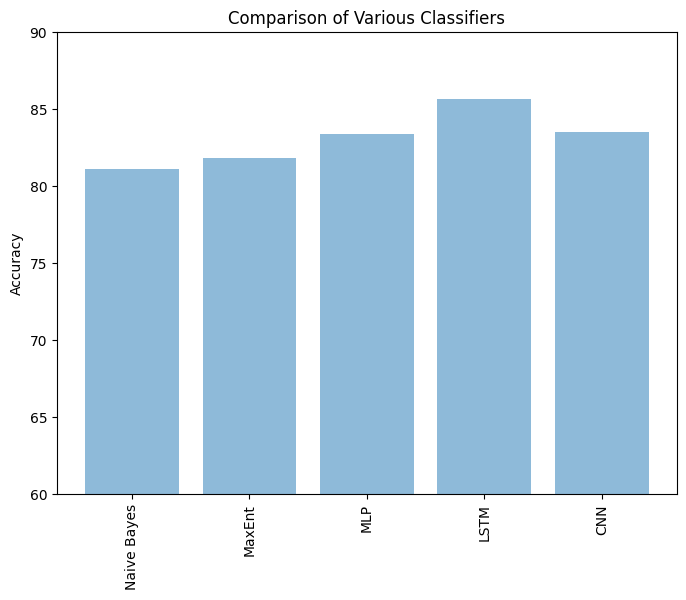

In [21]:
classifiers = ['Naive Bayes', 'MaxEnt','MLP', 'LSTM', 'CNN']
accuracies = [81.0945, 81.8, 83.4,85.65, 83.5]
plt.figure(4, [8,6])
plt.bar(range(len(classifiers)), accuracies, align='center', alpha=0.5)
plt.xticks(range(len(classifiers)), classifiers, rotation=90)
plt.ylabel('Accuracy')
plt.title('Comparison of Various Classifiers')
plt.ylim([60, 90])
plt.show();

##### 8. Discussion:
##### 8.1 Merits and Demerits:
   1. Naive Bayes:

        1.1 Merits:

        Simplicity and Speed: Naive Bayes is computationally efficient and straightforward to implement.

        Good for High Dimensions: Performs well even in high-dimensional spaces, making it suitable for text classification with         a large number of features.

        Decent Performance with Text Data: Despite its simplicity, Naive Bayes often performs surprisingly well on text        classification tasks, especially when the independence assumption holds reasonably well.

        1.2 Demerits:

        Assumption of Independence: The model assumes that features are conditionally independent, which might not hold true in real-world scenarios.

        Lack of Model Complexity: Naive Bayes might not capture intricate relationships in data, leading to suboptimal performance in tasks with complex dependencies.

        Sensitive to Feature Quality: Performance can degrade if the quality of features is not carefully considered.

   2. Maximum Entropy (Logistic Regression):

        2.1 Merits:

        Probabilistic Output: Outputs probabilities, allowing for better interpretability.

        Flexibility: Can handle both linear and non-linear relationships effectively.

        Well-Suited for Text Classification: Often used in natural language processing tasks and text analysis.

        2.2 Demerits:
        Need for Sufficient Data: Requires a relatively large amount of data to generalize well.

        Prone to Overfitting: Especially in cases with a high feature dimensionality.

        Computational Complexity: Training can be computationally expensive for large datasets.

   3. Multi-Layer Perceptron (MLP):

        3.1 Merits:

        Non-Linearity: Can learn complex non-linear relationships in data.

        Adaptability: Effective for various tasks, including text analysis, when properly configured.

        Representation Learning: Automatically learns hierarchical feature representations.

        3.2 Demerits:

        computational Intensity: Training deep architectures can be computationally expensive.

        Sensitivity to Hyperparameters: Performance heavily depends on the choice of hyperparameters.

        Need for Sufficient Data: Requires a substantial amount of labeled data to avoid overfitting.

   4. Recurrent Neural Networks (RNNs):

        4.1 Merits:

        Sequential Modeling: Effective in capturing sequential dependencies in data, making them suitable for tasks involving text sequences.

        Variable-Length Input: Can handle inputs of varying lengths, crucial for text analysis.

        Stateful Memory: Can remember information over long sequences due to their inherent memory cells.

        4.2 Demerits:

        Vanishing and Exploding Gradients: Training difficulties arising from vanishing or exploding gradients can affect long sequences.

        Computational Intensity: Training RNNs can be computationally expensive, and parallelization is challenging.

        Limited Context Window: Might struggle with capturing very long-term dependencies.

   5. Convolutional Neural Networks (CNNs):

        5.1 Merits:

        Local Feature Learning: Effective in learning local patterns and features.

        Parameter Sharing: Reduces the number of parameters, making it computationally efficient.

        Translation Invariance: Can capture hierarchical features invariant to translation, making them robust.

       5.2 Demerits:

        Fixed Input Size: Struggles with variable-length input sequences without additional mechanisms.

        Limited Sequential Modeling: Might not capture long-term dependencies as effectively as RNNs.

        Sensitivity to Hyperparameters: Performance can be sensitive to the choice of hyperparameters.



##### 8.2  Possible Future Work :
   We can improve these models to handle more diverse and complex database. Some possible advancement can be done in following ways:

   1. Transfer Learning and Pre-training:
   
       transfer learning techniques and pre-training strategies, such as using pre-trained language models like BERT (Bidirectional Encoder Representations from Transformers) or GPT (Generative Pre-trained Transformer), and fine-tuning them for specific text analysis tasks. This can lead to improved performance, especially when dealing with limited labeled data.
   2. Handling Multimodal Data:

       Extend text analysis models to handle multimodal data, combining information from text, images, audio, and other modalities. This can be particularly beneficial in applications like sentiment analysis of social media posts that often include images or videos.
   3. User Feedback Integration: 

       Integrate user feedback loops into text analysis systems for continuous improvement. Develop mechanisms for users to provide feedback on model predictions, allowing the system to adapt and refine its performance based on user input.
